In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from cv2 import bilateralFilter
from ipywidgets import interact, IntSlider, RadioButtons,FloatSlider, Checkbox

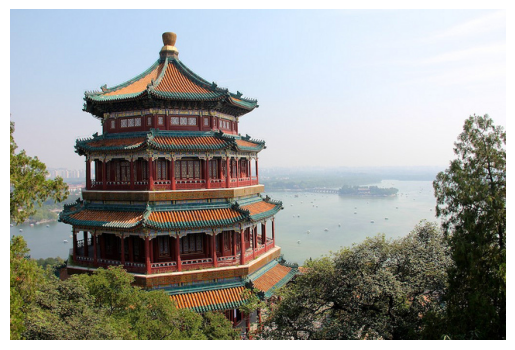

In [2]:
image = plt.imread('china-original.png')
plt.axis('off')
plt.imshow(image)

### The noisy image is created
> For 255 bit representation we must 255 * sigma

### Trying to deonoise the noisy image via convolving/cross-correlating with uniform, gaussian, median(for salt & pepper noise) and bilateral kernels.
- > Since the kernels are full symmetric convolving and cross-correlating does not make any difference.
- > The only computationally efficient gaussian filter is a 3x3 filter. by **computationally efficient**, I mean to use only integers and divide by 16 so that the array bits are right shifted 4 times(My researches for a way to implement shifting in numpy did not make any result. Try `np.int8(4)>>3` or `np.float16(4)>>3`). However, Various sizes are imlemented but apparently changing the `kernel_size` does not make any serious impact.
- > If `sigma=0`, just a blurring kernel is applied
- > Further optimization for blurring may be applied. e.g. **symmetric zero padding**(dark edges around image)
- > Bilateral parameters are hard to chose. current settings might not perform well.

In [3]:
gaussian3x3 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
def denoise(noise_mode, kernel_size, kernel_mode, sigma):
    fixed_image = np.zeros_like(image)
    if noise_mode == 'gaussian':
        noise = sigma * np.random.randn(*image.shape)
        noisy_image = image + noise
    else:
        noise_index = np.floor(np.random.random(image.size//100) * image.size).astype(np.uint32)
        noise = np.random.random(noise_index.size)
        noise[noise>.5] = 1
        noise[noise<.5] = 0
        noise = noise.astype(np.uint8)
        noisy_image = image.flatten()
        noisy_image[noise_index] = noise
        noisy_image = noisy_image.reshape(image.shape)
    if kernel_mode == 'uniform':
        for ch_i in range(3):
            ch = noisy_image[:,:,ch_i]
            fixed_image[:,:,ch_i] = sp.signal.correlate2d(ch, np.ones((kernel_size,kernel_size))/kernel_size**2,'same')
    elif kernel_mode == 'gaussian':
        if kernel_size == 3:
            for ch_i in range(3):
                ch = noisy_image[:,:,ch_i]
                fixed_image[:,:,ch_i] = sp.signal.correlate2d(ch, gaussian3x3,'same')
        else:
            kernel = np.zeros((kernel_size, kernel_size))
            kernel[kernel_size // 2, kernel_size // 2] = 1
            for ch_i in range(3):
                ch = noisy_image[:,:,ch_i]
                fixed_image[:,:,ch_i] = sp.signal.correlate2d(ch, sp.ndimage.gaussian_filter(kernel,.8),'same')
    elif kernel_mode == 'median':
        for ch_i in range(3):
                ch = noisy_image[:,:,ch_i]
                fixed_image[:,:,ch_i] = sp.signal.medfilt2d(ch, kernel_size)
    else:
        noisy_image = noisy_image.astype(np.float32)
        for ch_i in range(3):
                ch = noisy_image[:,:,ch_i]
                fixed_image[:,:,ch_i] = bilateralFilter(ch, 9, .1, 25, kernel_size)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax2.imshow(fixed_image.clip(0,1))
    ax2.set_title('denoised')
    ax2.axis('off')
    ax1.set_title('noisy image')
    ax1.imshow(noisy_image.clip(0,1))
    ax1.axis('off')
    plt.tight_layout()
    plt.show()

kernel_size_slider = IntSlider(min=1, max=15, step=2, value=7, description='Kernel Size:')
sigma_slider = FloatSlider(min=0, max=1, step=.05, value=.5, description='Sigma:')
kernel_mode_radio = RadioButtons(options=['uniform', 'gaussian', 'median', 'bilateral'], description='Kernel Mode:', value='gaussian')
noise_mode_radio = RadioButtons(options=['SP', 'gaussian'], description='Noise Mode:', value='gaussian')

interact(denoise,noise_mode=noise_mode_radio , kernel_size=kernel_size_slider, kernel_mode=kernel_mode_radio, sigma=sigma_slider)

interactive(children=(RadioButtons(description='Noise Mode:', index=1, options=('SP', 'gaussian'), value='gaus…

<function __main__.denoise(noise_mode, kernel_size, kernel_mode, sigma)>

## Image sharpening
### Method 1: Sharpening kernel, only in the following form, is applied. 
| -1 | -1 | ... | ... | ... |
|----|----|----|----|----|
| **-1** |  **...** | **...** | **...** | **...** |
| **...** |  **...** | **x** | **...** | **...** |
| **...** |  **...** | **...** | **...** | **-1** |
| **...** | **...** | **...** | **-1** | **-1** |

### Method 2: 2 * image - blurred image

In [4]:
def sharpen(kernel_size, intensity):
    sharpened_image = np.zeros_like(image)
    kernel = -1 * np.ones((kernel_size, kernel_size))
    kernel[kernel_size // 2, kernel_size // 2] = intensity
    matsum = np.sum(kernel)
    kernel /= matsum
    for ch_i in range(3):
        ch = image[:, :, ch_i]
        sharpened_image[:, :, ch_i] = sp.signal.correlate2d(ch, kernel, mode='same')
    sharpened_image = np.clip(sharpened_image, 0, 1)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(sharpened_image)
    ax2.set_title('Sharpened Image')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

kernel_size_slider = IntSlider(min=1, max=15, step=2, value=3, description='Kernel Size:')
intensity_slider = IntSlider(min=1, max=30, step=1, value=15, description='Intensity:')

interact(sharpen, kernel_size=kernel_size_slider, intensity=intensity_slider)

interactive(children=(IntSlider(value=3, description='Kernel Size:', max=15, min=1, step=2), IntSlider(value=1…

<function __main__.sharpen(kernel_size, intensity)>

### Reflect Padding solution:

In [5]:
def blur(kernel_size=5, padding=True):
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2
    res = np.zeros_like(image)
    if padding:
        padding_size = int((kernel_size - 1) / 2)
        h,w = np.array(image.shape[:2])
        temp = np.zeros((3*h,3*w,3))
        v_flip = image[::-1,:,:]
        h_flip = image[:,::-1,:]
        c_flip = image[::-1,::-1,:]
        temp[h:2*h,w:2*w,:] = image # center
        temp[:h,w:2*w,:] = v_flip # top
        temp[2*h:,w:2*w,:] = v_flip # bottom
        temp[h:2*h,:w,:] = h_flip # left
        temp[h:2*h,2*w:,:] = h_flip # right
        temp[:h,:w,:] = c_flip # top left
        temp[2*h:,:w,:] = c_flip # bottom left
        temp[:h,2*w:,:] = c_flip # top right
        temp[2*h:,2*w:,:] = c_flip # bottom right
        temp = temp[h - padding_size:2*h + padding_size, w - padding_size:2*w + padding_size,:]
        for i in range(3):
            res[:,:,i] = sp.signal.correlate2d(temp[:,:,i], kernel, mode='valid')
    else:
        for i in range(3):
            res[:,:,i] = sp.signal.correlate2d(image[:,:,i], kernel, mode='same')
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(res)
    ax2.set_title('Blurred Image')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

kernel_size_slider = IntSlider(min=1, max=33, step=2, value=3, description='Kernel Size:')
paddin_check = Checkbox(value=False,description='Padding:',disabled=False)
interact(blur, kernel_size=kernel_size_slider, padding=paddin_check)

interactive(children=(IntSlider(value=3, description='Kernel Size:', max=33, min=1, step=2), Checkbox(value=Fa…

<function __main__.blur(kernel_size=5, padding=True)>

### Bilateral filter: Theoretical

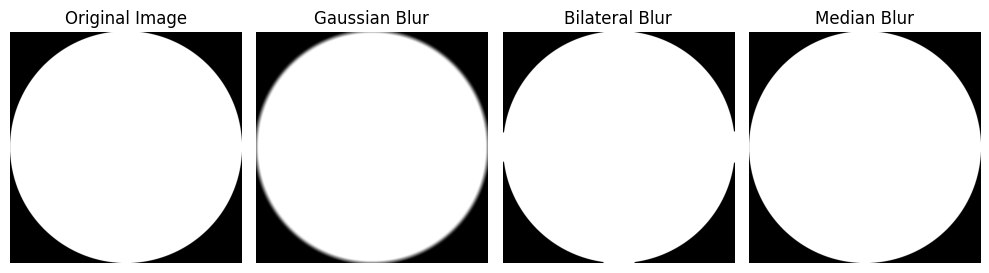

In [6]:
kernel_size = 41
n = 2000
r = n // 2
y, x = np.ogrid[:n, :n]
circle = ((x - r)**2 + (y - r)**2 <= r**2).astype(np.uint8)
g_blur = sp.signal.correlate2d(circle, np.ones((kernel_size,kernel_size))/kernel_size**2,'same')
b_blur = bilateralFilter(circle, kernel_size,5,25)
m_blur = sp.signal.medfilt2d(circle, kernel_size)
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,40))
ax1.imshow(circle,'gray')
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(g_blur,'gray')
ax2.set_title('Gaussian Blur')
ax2.axis('off')
ax3.imshow(b_blur,'gray')
ax3.set_title('Bilateral Blur')
ax3.axis('off')
ax4.imshow(m_blur,'gray')
ax4.set_title('Median Blur')
ax4.axis('off')
plt.tight_layout()
plt.show()

### Bilateral and Median filters are more robust to outliers and adge